In [53]:
# is a good pratice only import what you need in the notebook , ill refactor this later in these notebooks :)

import sys
sys.path.append(r'C:\Users\bield\Documents\projsData\proj-1\utils')

from utils import createSparkSesion
from pyspark.sql import (functions as F,
                                        Window)
import matplotlib.pyplot as plt
import pandas as pd



In [54]:
spark = createSparkSesion()

In [55]:
spark.sparkContext

<SparkContext master=local[*] appName=Analises>

In [56]:
def rename_columns(df, dic):
    df_columns = df.columns

    for column in df_columns:
        try:
            
            new_name = dic[column]
            df = df.withColumnRenamed(column, new_name)
        except KeyError:
            if column in dic.values():
                print("column already renamed")
            else:
                print(f"column not found in dict {column} , {KeyError}")#tratando erros

    return df    

In [57]:
#padronizando as colunas e deixando o entendimento mais facil por meio dos proprios nomes
rename_columns_dic = {
                    "ProdutoID"     :"product_id",
                    "VendasID"      :"sale_id",
                    "Quantidade"    :"quantity",
                    "ValorUnitario" :"unit_value",
                    "ValorTotal"    :"total_value",
                    "ClienteID"     :"customer_id",
                    "Cliente"       :"customer_name",
                    "Estado"        :"state",
                    "Genero"        :"gender",
                    "Status"        :"client_tier",
                    "Produto"       :"product_name",
                    "Preco"         :"price",
                    "VendedorID"    :"seller_id",
                    "Data"          :"date",
                    "Total"         :"sale_total_amount",
                    "Vendedor"      :"seller_name",
                    "Desconto"      :"discount_amount"
                    }

In [58]:
prefix = r"../../datasets/download/Atividades/"


In [59]:
df_customers   = spark.read.parquet(f"{prefix}/Clientes.parquet")
df_sales_itens = spark.read.parquet(f"{prefix}/ItensVendas.parquet")
df_products    = spark.read.parquet(f"{prefix}/Produtos.parquet")
df_sales       = spark.read.parquet(f"{prefix}/Vendas.parquet")
df_seller      = spark.read.parquet(f"{prefix}/Vendedores.parquet")

In [60]:
df_customers.takePandas(2)

,ClienteID,Cliente,Estado,Genero,Status
0,1,Adelina Buenaventura,RJ,M,Silver
1,2,Adelino Gago,RJ,M,Silver


In [61]:
df_customers.printSchema()

root
 |-- ClienteID: long (nullable = true)
 |-- Cliente: string (nullable = true)
 |-- Estado: string (nullable = true)
 |-- Genero: string (nullable = true)
 |-- Status: string (nullable = true)



df_customers

notes : 

customer_id as long type could be a problem in distributed systems ...


In [62]:
df_sales_itens.takePandas(2)

,ProdutoID,VendasID,Quantidade,ValorUnitario,ValorTotal,Desconto,TotalComDesconto
0,2,400,2,9201.0,18402.0,"6256,68",12145.32
1,2,385,2,9201.0,18402.0,"5704,62",12697.38


In [63]:
df_sales_itens.printSchema()

root
 |-- ProdutoID: long (nullable = true)
 |-- VendasID: long (nullable = true)
 |-- Quantidade: long (nullable = true)
 |-- ValorUnitario: double (nullable = true)
 |-- ValorTotal: double (nullable = true)
 |-- Desconto: string (nullable = true)
 |-- TotalComDesconto: double (nullable = true)



df_sales_itens

notes :

discount_amount have "," , but the column total_discount has "." + one is a string a other a double , convert both to double

In [64]:
df_products.takePandas(2)

,ProdutoID,Produto,Preco
0,1,Bicicleta Aro 29 Mountain Bike Endorphine 6.3 ...,"8.852,00"
1,2,Bicicleta Altools Stroll Aro 26 Freio À Disco ...,"9.201,00"


In [65]:
df_products.printSchema()

root
 |-- ProdutoID: long (nullable = true)
 |-- Produto: string (nullable = true)
 |-- Preco: string (nullable = true)



df_products

note:

price column is a string format , and have "," instead of "." , fix and convert


In [66]:
df_sales.takePandas(2)

,VendasID,VendedorID,ClienteID,Data,Total
0,1,1,91,1/1/2019,8053.6
1,2,6,185,1/1/2020,150.4


In [67]:
df_sales.printSchema()

root
 |-- VendasID: long (nullable = true)
 |-- VendedorID: long (nullable = true)
 |-- ClienteID: long (nullable = true)
 |-- Data: string (nullable = true)
 |-- Total: double (nullable = true)



df_sales

note:

date column should be converted as timestamp ou date_time format

In [68]:
df_seller.takePandas(2)

,VendedorID,Vendedor
0,1,Armando Lago
1,2,Capitolino Bahía


In [69]:
df_seller.printSchema()

root
 |-- VendedorID: long (nullable = true)
 |-- Vendedor: string (nullable = true)



my objective here is not to do a profund business analysis , just a few insights to build a pyspark code , and exemplify my abilities in build a ETL , exploration data analysis (EDA), denormazile tables etc...

In [70]:
#to do

#sales mans metrics
#with seller give more discounts
#best sellers by month >by amount , by sales
#objective  > identify best emplooyes ,for maybe a bonus , and find a possible corelation between give discounts, and be the best seller



#customers metrics 
#top customer , by amount , by recurrence
#maybe detect with customer we could offer discounts , send marketing campaings, trigger some fidelity bonus etc...

#store metrics:
#month over month
#month distribuition , by amount , by untary sales
#understando general store metrics



#product metrics:
#top product , by unitys sold, by amount
#understand which product we sell more , for some kind of storage managment , tendencies etc..

# put some graphs after all



<h1>Sellers metrics 

a maneger could use this etl to track sellers performance , for example

In [71]:
df_sellers_metrics  = (
                        df_sales.join(df_seller,on="VendedorID",how="left")
                                .join(df_sales_itens,on="VendasID",how="left")
                                .select(
                                        F.expr("VendasID as sale_id"),
                                        F.expr("Vendedor as seller_name"),
                                        F.expr("Total as total_sale_amount"),
                                        F.expr("ProdutoId as product_id"),
                                        F.expr("TotalComDesconto as item_final_price_with_discont"),
                                        F.expr("Desconto as discont"),
                                        F.expr("Data as date")
                                        )
                                .withColumn("discont",
                                                        F.when(F.col("discont").rlike(r"-"),0.00)
                                                         .otherwise(
                                                                        F.regexp_replace(F.col("discont"),r",",r".")
                                                                        .cast("double")) # tratando os nulos
                                            )
                                .withColumn("date",F.to_date(F.to_timestamp(F.col("date"), "d/M/yyyy"))) # cast para time stamp facilita funcoes de calculo e operacoes com datas
                                .withColumn("month",F.month(F.col("date")))
                                .withColumn("year",F.year(F.col("date")))
                                .drop("date")
                        )

In [72]:
total_sales_value_window        = Window.partitionBy("month","year").orderBy(F.desc("total_sales_value"))
total_sales_window              = Window.partitionBy("month","year").orderBy(F.desc("total_sales"))
total_discount_given_window     = Window.partitionBy("month","year").orderBy(F.desc("total_discount_given"))

In [73]:
df_top_sellers = (df_sellers_metrics
                        .groupBy("month","year","seller_name")
                        .agg(
                            F.sum("total_sale_amount").alias("total_sales_value"),
                            F.count("sale_id").alias("total_sales"),
                            F.sum("discont").alias("total_discount_given")
                            )
                        .withColumn("rank_seller_by_amount" ,F.rank().over(total_sales_value_window))
                        .withColumn("rank_seller_by_sales"  ,F.rank().over(total_sales_window))
                        .withColumn("rank_seller_by_discont",F.rank().over(total_discount_given_window))
                        .select("month","year","seller_name","total_sales_value","rank_seller_by_amount","total_sales","rank_seller_by_sales","total_discount_given","rank_seller_by_discont")#just to order column orders
                        )

In [74]:
df_top_sellers.filter((F.col("month")==1)&(F.col("year")==2020)).takePandas(20)

,month,year,seller_name,total_sales_value,rank_seller_by_amount,total_sales,rank_seller_by_sales,total_discount_given,rank_seller_by_discont
0,1,2020,Hélio Liberato,18402.00,5,1,7,184.02,1
1,1,2020,Godo Capiperibe,47467.20,1,3,4,88.52,2
2,1,2020,Jéssica Castelão,37258.58,3,11,1,78.28,3
3,1,2020,Daniel Pirajá,40878.12,2,4,2,61.54,4
4,1,2020,Iberê Lacerda,9711.88,6,3,4,24.19,5
5,1,2020,Armando Lago,526.16,7,2,6,2.63,6
6,1,2020,Capitolino Bahía,33357.08,4,4,2,0.00,7


In [75]:
# after all this ET(~L) process i could Load this date somewhere , maybe in a db where a manager could access  , schedulle this pipe on airflow etc..

<h1>Customer metrics

In [76]:
 #clients metrics 
#top client , by amount , by recurrence
#top item purchased by customer
#maybe detect with client we could offer discounts , send marketing campaings, trigger some fidelity bonus, holidays campaings etc...

Idealmente focando na performance , eu deveria desnormalizar olhando para os ids e posteriormente ja com o resultado esperado cruzar para obter os campos descritivos, para economizar memoria ram em um cenario de big data 
mas esse nao é o caso...

data > timestamp > date
desconto > tratar nulos


In [77]:
# isso deveria ter sido feito logo de primeira , so percebi posteriormente ,  mas mantive separado para demonstrar outras abordagens no codigo ...
df_sales        = rename_columns(df_sales,       rename_columns_dic)
df_sales_itens  = rename_columns(df_sales_itens, rename_columns_dic)
df_products     = rename_columns(df_products,    rename_columns_dic)
df_customers    = rename_columns(df_customers,   rename_columns_dic)

column not found in dict TotalComDesconto , <class 'KeyError'>


In [78]:
df_customers_metrics = (  df_customers.join(df_sales,on="customer_id",how="left")
                                   .join(df_sales_itens,on="sale_id",how="left")
                                   .join(df_products,on="product_id",how="left")
                                   .withColumn("date",F.to_date(F.to_timestamp(F.col("date"),"d/m/yyyy")))
                                   .withColumn("month",F.month(F.col("date")))
                                   .withColumn("year",F.year(F.col("date")))
                                   .drop("product_id","customer_id","seler_id","date")
                                   .withColumn(
                                                "discount_amount",
                                                F.when(
                                                    (F.col("discount_amount").rlike(r"-")) | (F.col("discount_amount") == ""),
                                                    0.00
                                                ).otherwise(
                                                    F.regexp_replace(F.col("discount_amount"), r",", r".").cast("double")
                                                )  # tratando os nulos  
                                            )
    
                        )

In [79]:
rank_customer_by_amount_spend_window        = Window.partitionBy("month","year").orderBy(F.desc("customer_total_spend"),F.desc("customer_total_purchases"),F.desc("customer_total_discount_amount"))
rank_customer_by_total_purchases_window     = Window.partitionBy("month","year").orderBy(F.desc("customer_total_purchases"),F.desc("customer_total_spend"),F.desc("customer_total_discount_amount"))
rank_customer_by_discount_recived_window    = Window.partitionBy("month","year").orderBy(F.desc("customer_total_discount_amount"),F.desc(F.col("discount_share")))#priorizar pelo menor share de desconto

columnOrderFinal = ["year","month","customer_name","customer_total_spend","rank_customer_by_amount","customer_total_purchases","rank_customer_by_total_purchases","customer_total_discount_amount","rank_customer_by_discount_recived"]

In [80]:
df_top_customers  = (df_customers_metrics
                        .groupBy("month","year","customer_name")
                        .agg(
                            F.sum(F.col("sale_total_amount")).alias("customer_total_spend"),
                            F.count(F.col("sale_id")).alias("customer_total_purchases"),
                            F.sum(F.col("discount_amount")).alias("customer_total_discount_amount")
                            
                        )
                        .withColumn("discount_share",F.expr("cast(customer_total_discount_amount as int)/customer_total_purchases"))
                        .withColumn("rank_customer_by_amount",F.rank().over(rank_customer_by_amount_spend_window))
                        .withColumn("rank_customer_by_total_purchases",F.rank().over(rank_customer_by_total_purchases_window))
                        .withColumn("rank_customer_by_discount_recived",F.rank().over(rank_customer_by_discount_recived_window))
                        .select(*columnOrderFinal)
                     )

In [81]:
df_top_customers.filter(F.col("year")==2020).takePandas()

,year,month,customer_name,customer_total_spend,rank_customer_by_amount,customer_total_purchases,rank_customer_by_total_purchases,customer_total_discount_amount,rank_customer_by_discount_recived
0,2020,1,Antão Corte-Real,535900.42,1,61,1,18598.34,1
1,2020,1,Cidália Miera,290705.97,2,34,2,11938.38,2
2,2020,1,Celestino Pereira,62342.32,10,5,14,5866.57,3
3,2020,1,Bárbara Magalhães,18402.00,26,1,40,5704.62,4
4,2020,1,Guadalupe Rodrigues,87541.20,6,3,24,5142.52,5


<h1>store metrics


In [83]:
#month over month
#month distribuition , by amount , by untary sales
#understand general store metrics

In [84]:
df_sales.takePandas()

,sale_id,seller_id,customer_id,date,sale_total_amount
0,1,1,91,1/1/2019,8053.60
1,2,6,185,1/1/2020,150.40
2,3,7,31,2/1/2020,6087.00
3,4,5,31,2/1/2019,13828.60
4,5,5,31,3/1/2018,26096.66


In [85]:
df_sales.printSchema()

root
 |-- sale_id: long (nullable = true)
 |-- seller_id: long (nullable = true)
 |-- customer_id: long (nullable = true)
 |-- date: string (nullable = true)
 |-- sale_total_amount: double (nullable = true)



In [86]:
df_store_metrics = (df_sales.withColumn("date",F.to_date(F.to_timestamp(F.col("date"),"d/m/yyyy")))
                            .withColumn("month_of_year",F.month(F.col("date")))
                            .withColumn("year",F.year(F.col("date")))
                            #.withColumn("week_of_month",F.floor((F.weekofyear(F.col("date"))/F.col("month_of_year"))))
                            )

In [87]:
df_store_metrics_monthly = (df_store_metrics.groupBy("year","month_of_year")
                                            .agg(
                                                F.sum(F.col("sale_total_amount")).alias("total_month_sales_amount"),
                                                F.count(F.col("sale_id")).alias("total_month_uniques_sales")
                                                )
                            )

In [88]:
df_store_metrics_monthly.takePandas()

,year,month_of_year,total_month_sales_amount,total_month_uniques_sales
0,2018,1,1079389.88,133
1,2019,1,1138664.78,147
2,2020,1,836108.07,120


In [ ]:
#few datas , going to mock some to plot a graph

In [89]:
def addMockData(df,years=[2019,2020,2021]):

    import random as R

    months = [2,3,4,5,6,7,8,9,10,11,12]

    avg_sale_total_amount     = df.select(F.expr("avg(total_month_sales_amount)")).collect()[0][0]
    avg_month_uniques_sales = df.select(F.expr("avg(total_month_uniques_sales)")).collect()[0][0]

    data   = []

    for year in years:
        for month in months :
            
            total_month_sales_amount  = avg_sale_total_amount   * R.uniform(0.8,1.25)
            total_month_uniques_sales = round(avg_month_uniques_sales * R.uniform(0.8,1.25))
            data.append({"year":f"{year}","month_of_year":f"{month}","total_month_sales_amount":f"{total_month_sales_amount}","total_month_uniques_sales":f"{total_month_uniques_sales}"})
    
    df_to_append = pd.DataFrame(data)
    df_to_append.to_csv("temp.csv",index=False,header=True)

    df_mocked = (df.unionByName(spark.read.csv("temp.csv",header=True))
                    .withColumn("total_month_sales_amount",F.round(F.col("total_month_sales_amount"),2))
                    .withColumn("year",F.col("year").cast("int"))
                    .withColumn("month_of_year",F.col("month_of_year").cast("int"))
                    .withColumn("total_month_uniques_sales",F.col("total_month_uniques_sales").cast("int")))

    return df_mocked


In [90]:
df_store_metrics_monthly_mocked = addMockData(df_store_metrics_monthly)

In [91]:
store_metrics_monthly_window = Window.orderBy("year","month_of_year")

In [96]:
df_store_metrics_monthly_final = (df_store_metrics_monthly_mocked.withColumn("row_number",F.row_number().over(store_metrics_monthly_window))
            .withColumn("MoM",
                        F.when(F.col("row_number")==1   ,  "0")
                        .otherwise(
                                    F.round(
                                            ((F.lag("total_month_sales_amount").over(Window.orderBy("row_number"))/F.col("total_month_sales_amount"))-1)    *   100,2)))
            .withColumn("year_month",F.concat(F.col("year"),F.lit("_"),F.col("month_of_year")))
            .drop("row_number"))

In [107]:
df_store_metrics_monthly_final.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month_of_year: integer (nullable = true)
 |-- total_month_sales_amount: double (nullable = true)
 |-- total_month_uniques_sales: integer (nullable = true)
 |-- MoM: string (nullable = true)
 |-- year_month: string (nullable = true)



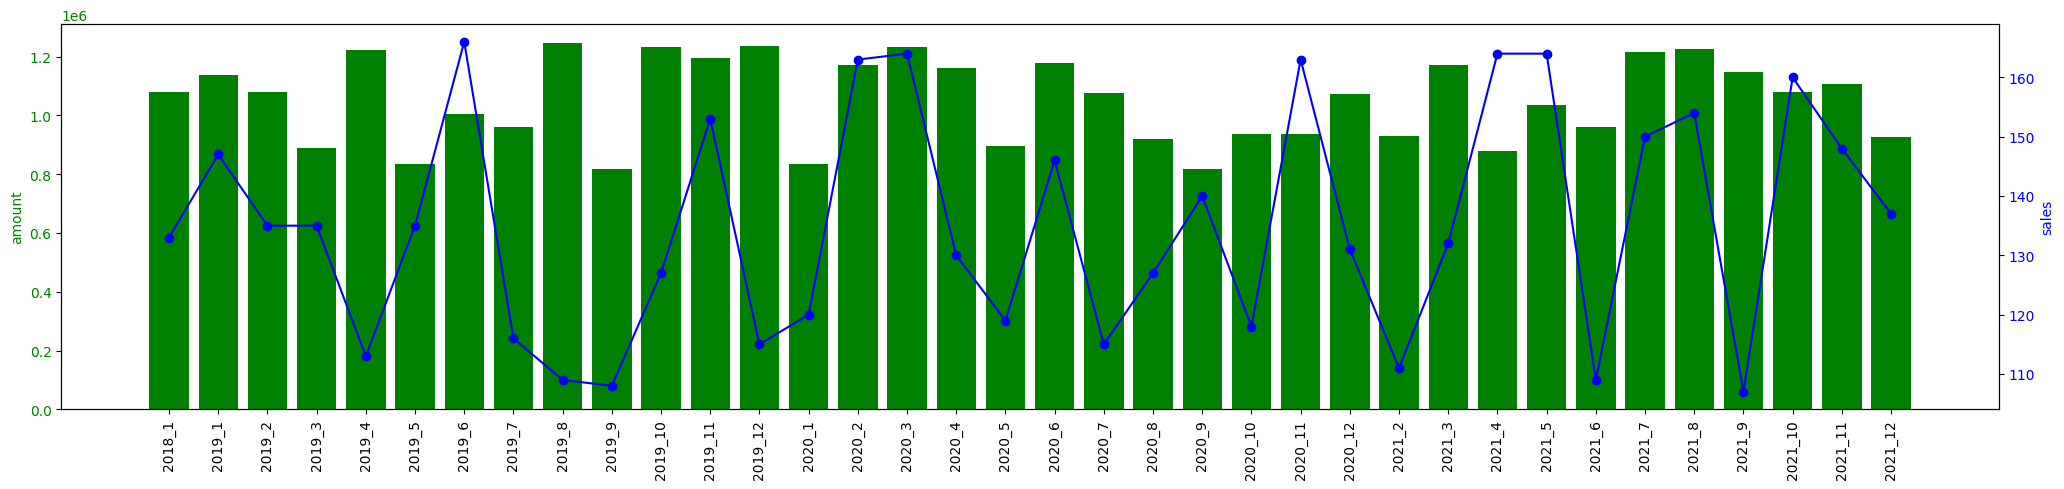

In [102]:
fig , ax1 = plt.subplots(figsize=(25,5))

ax1.set_ylabel('amount', color='g')
ax1.tick_params(axis='y', labelcolor='g')
ax1.bar(df_store_metrics_monthly_final.toPandas()['year_month'],df_store_metrics_monthly_final.toPandas()['total_month_sales_amount'],color="g")

ax1.tick_params(axis='x',rotation=90)

ax2 = ax1.twinx()
ax2.set_ylabel("sales",color='b')
ax2.tick_params(axis='y', labelcolor='b')
ax2.plot(df_store_metrics_monthly_final.toPandas()['year_month'],df_store_metrics_monthly_final.toPandas()['total_month_uniques_sales'],color='b', marker='o')

In [103]:
#this graph does not show any tendencies , because its a random mocked data ...

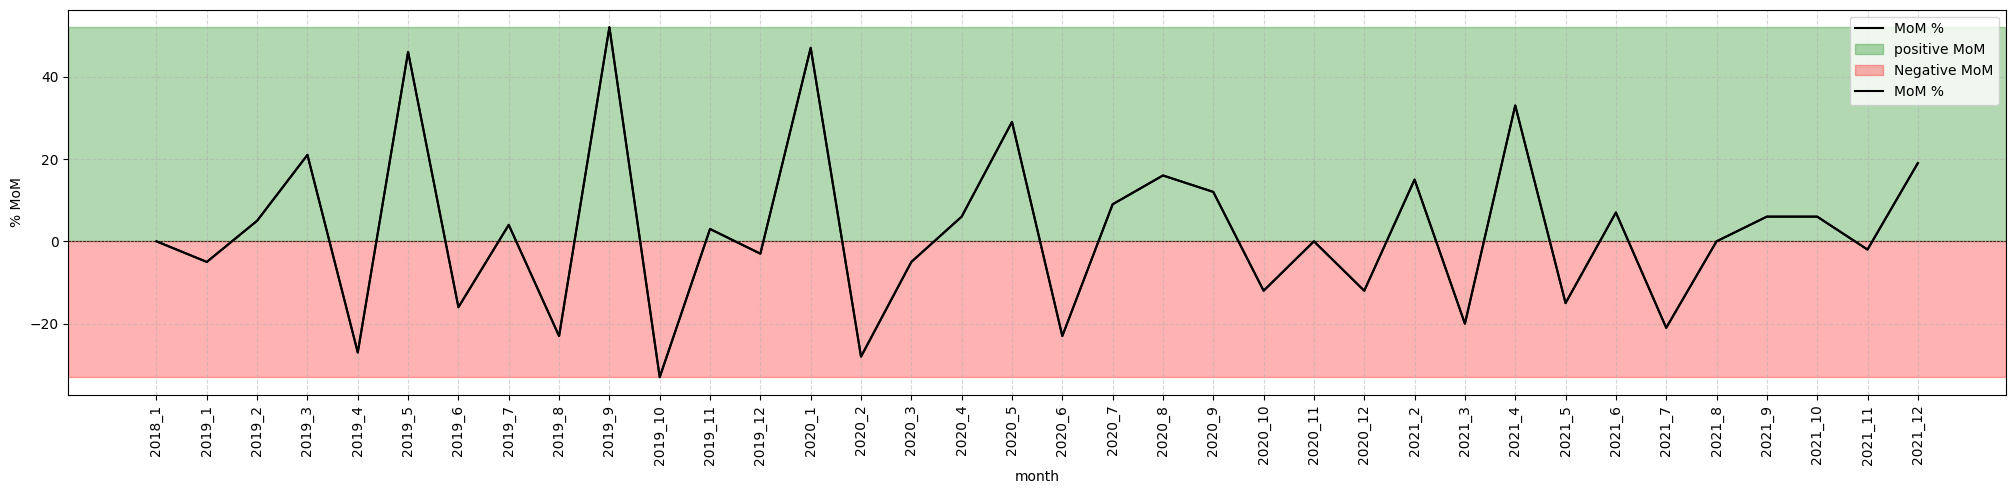

In [ ]:
fig,ax = plt.subplots(figsize=(25,5))

x = df_store_metrics_monthly_final.toPandas()['year_month']
y = df_store_metrics_monthly_final.withColumn("MoM",F.col("MoM").cast("int")).toPandas()['MoM']
ax.plot(x,y, color="black", label="MoM %")

ax.axhspan(0, y.max(), color='green', alpha=0.3, label="positive MoM")
ax.axhspan(y.min(), 0, color='red', alpha=0.3, label="Negative MoM")

ax.plot(x, y, color="black", label="MoM %")

ax.tick_params(axis='x', rotation=90)
ax.set_ylabel("% MoM")
ax.set_xlabel("month")
ax.axhline(0, color="black", linewidth=0.5, linestyle="--") 
ax.legend()
ax.grid(True, linestyle="--", alpha=0.5)

plt.show()